In [18]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import lightgbm as lgb
import pandas as pd
import numpy as np
import datetime
from sklearn.preprocessing import LabelEncoder
from multiprocessing import Pool
import subprocess
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
import pprint
import os

from features import get_features

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load Data

In [2]:
df_train = pd.read_csv("input/parsed_train.csv", dtype={'fullVisitorId': 'str'})
df_test = pd.read_csv("input/parsed_test.csv", dtype={'fullVisitorId': 'str'})

/Users/hyundai/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Feature Engineering

In [3]:
df_train = get_features(df_train)
df_test = get_features(df_test)

'fea_date_time'  10806.49 ms
'fea_format'  1769.32 ms
'fea_device'  609.23 ms
'fea_totals'  2196.40 ms
'fea_geo_network'  1063.95 ms
'fea_traffic_source'  2794.99 ms
'fea_date_time'  9276.55 ms
'fea_format'  1557.97 ms
'fea_device'  539.70 ms
'fea_totals'  2157.84 ms
'fea_geo_network'  914.91 ms
'fea_traffic_source'  2637.50 ms


### Split X and y, Remove not_used_cols

In [4]:
target_col = 'totals_transactionRevenue'

df_train_y = df_train[target_col]
df_train_y.fillna(0, inplace=True)
df_train_y = df_train_y.astype(int)
df_train_y[df_train_y != 0] = 1
df_train_y.value_counts(dropna=False)

0    892138
1     11515
Name: totals_transactionRevenue, dtype: int64

In [5]:
not_used_cols = [
    "visitNumber", "date", "fullVisitorId", "sessionId", "visitId",
    "visitStartTime", 'trafficSource_referralPath',
    'trafficSource_campaignCode', target_col,
]
df_train_idx = df_train[['fullVisitorId']]
df_train_X = df_train.drop(not_used_cols, axis=1)

df_test_idx = df_test[['fullVisitorId']]
del_cols = list(set(df_test.columns) & set(not_used_cols))
df_test_X = df_test.drop(del_cols, axis=1)

In [6]:
print(df_train_X.columns)
print(df_test_X.columns)

Index(['channelGrouping', 'socialEngagementType', 'device_browser',
       'device_browserSize', 'device_browserVersion', 'device_deviceCategory',
       'device_flashVersion', 'device_isMobile', 'device_language',
       'device_mobileDeviceBranding', 'device_mobileDeviceInfo',
       'device_mobileDeviceMarketingName', 'device_mobileDeviceModel',
       'device_mobileInputSelector', 'device_operatingSystem',
       'device_operatingSystemVersion', 'device_screenColors',
       'device_screenResolution', 'geoNetwork_city', 'geoNetwork_cityId',
       'geoNetwork_continent', 'geoNetwork_country', 'geoNetwork_latitude',
       'geoNetwork_longitude', 'geoNetwork_metro', 'geoNetwork_networkDomain',
       'geoNetwork_networkLocation', 'geoNetwork_region',
       'geoNetwork_subContinent', 'totals_bounces', 'totals_hits',
       'totals_newVisits', 'totals_pageviews', 'totals_visits',
       'trafficSource_adContent',
       'trafficSource_adwordsClickInfo.adNetworkType',
       'trafficS

### Label Encoding

In [7]:
categorical_feature = list(df_train_X.select_dtypes(exclude=np.number).columns)
print(categorical_feature)

df_train_X[categorical_feature].fillna('NA_NULL', inplace=True)
df_train_X.fillna(0, inplace=True)

df_test_X[categorical_feature].fillna('NA_NULL', inplace=True)
df_test_X.fillna(0, inplace=True)

for c in categorical_feature:
#     print(c)
    lbl = LabelEncoder()
    lbl.fit(
        list(df_train_X[c].values.astype('str')) +
        list(df_test_X[c].values.astype('str')))
    df_train_X[c] = lbl.transform(list(df_train_X[c].values.astype('str')))
    df_test_X[c] = lbl.transform(list(df_test_X[c].values.astype('str')))

['channelGrouping', 'socialEngagementType', 'device_browser', 'device_browserSize', 'device_browserVersion', 'device_deviceCategory', 'device_flashVersion', 'device_isMobile', 'device_language', 'device_mobileDeviceBranding', 'device_mobileDeviceInfo', 'device_mobileDeviceMarketingName', 'device_mobileDeviceModel', 'device_mobileInputSelector', 'device_operatingSystem', 'device_operatingSystemVersion', 'device_screenColors', 'device_screenResolution', 'geoNetwork_city', 'geoNetwork_cityId', 'geoNetwork_continent', 'geoNetwork_country', 'geoNetwork_latitude', 'geoNetwork_longitude', 'geoNetwork_metro', 'geoNetwork_networkDomain', 'geoNetwork_networkLocation', 'geoNetwork_region', 'geoNetwork_subContinent', 'trafficSource_adContent', 'trafficSource_adwordsClickInfo.adNetworkType', 'trafficSource_adwordsClickInfo.criteriaParameters', 'trafficSource_adwordsClickInfo.gclId', 'trafficSource_adwordsClickInfo.isVideoAd', 'trafficSource_adwordsClickInfo.slot', 'trafficSource_campaign', 'traffic

/Users/hyundai/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


### Training

In [8]:
df_val_X = df_train_X
df_val_y = df_train_y

feature_name = list(df_train_X.columns)

train = lgb.Dataset(
    df_train_X.values,
    label=df_train_y.values,
    feature_name=feature_name,
    categorical_feature=categorical_feature)

valid = lgb.Dataset(
    df_val_X.values,
    label=df_val_y.values,
    feature_name=feature_name,
    categorical_feature=categorical_feature)

params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'class_weight': 'balanced',
    "max_depth": 8,
    "min_child_samples": 20,
    "reg_alpha": 1,
    "reg_lambda": 1,
    "num_leaves": 257,
    "learning_rate": 0.01,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "subsample_freq ": 5,
}

evals_result = {}
train_params = {
    'params': params,
    'train_set': train,
    'valid_sets': [train, valid],
    'valid_names': ['train', 'valid'],
    'evals_result': evals_result,
    'early_stopping_rounds': 100,  #50
    'num_boost_round': 200,  #500
    'verbose_eval': 10,
    'feval': None,
    #     'categorical_feature': 'auto',
}

model = lgb.train(**train_params)

n_estimators = model.best_iteration

/Users/hyundai/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1158: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/hyundai/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:725: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[10]	train's auc: 0.985646	valid's auc: 0.985646
[20]	train's auc: 0.988024	valid's auc: 0.988024
[30]	train's auc: 0.988246	valid's auc: 0.988246
[40]	train's auc: 0.988459	valid's auc: 0.988459
[50]	train's auc: 0.988643	valid's auc: 0.988643
[60]	train's auc: 0.98879	valid's auc: 0.98879
[70]	train's auc: 0.988966	valid's auc: 0.988966
[80]	train's auc: 0.989099	valid's auc: 0.989099
[90]	train's auc: 0.9892	valid's auc: 0.9892
[100]	train's auc: 0.989305	valid's auc: 0.989305
[110]	train's auc: 0.989408	valid's auc: 0.989408
[120]	train's auc: 0.989519	valid's auc: 0.989519
[130]	train's auc: 0.989617	valid's auc: 0.989617
[140]	train's auc: 0.989706	valid's auc: 0.989706
[150]	train's auc: 0.98979	valid's auc: 0.98979
[160]	train's auc: 0.989857	valid's auc: 0.989857
[170]	train's auc: 0.989942	valid's auc: 0.989942
[180]	train's auc: 0.990026	valid's auc: 0.990026
[190]	train's auc: 0.990117	valid's auc: 0.990117
[200

### Evaluation

In [15]:
y_pred_train = model.predict(df_train_X, num_iteration=model.best_iteration)
y_pred = model.predict(df_test_X, num_iteration=model.best_iteration)

In [19]:
# Init result configurations
RESULT_PATH = 'results'

time_tag = datetime.datetime.now().strftime('%Y-%m-%dT%H%M%S')
result_path = os.path.join(RESULT_PATH, time_tag)

os.makedirs(result_path, exist_ok=True)
# Create train set raw result file
df_res = df_train_idx
df_res['y_true'] = df_train_y.values
df_res['y_pred'] = y_pred_train
file_name = 'clf_train_{}.csv'.format(time_tag)
df_res.to_csv(os.path.join(result_path, file_name), index=False)
print('raw_train:', os.path.join(result_path, file_name))

# Create train set raw result file
df_res = df_test_idx
df_res['y_pred'] = y_pred
file_name = 'clf_test_{}.csv'.format(time_tag)
df_res.to_csv(os.path.join(result_path, file_name), index=False)
print('raw_test:', os.path.join(result_path, file_name))

# Create submit file
df_test_idx['PredictedLogRevenue'] = 0
df_test_idx['PredictedLogRevenue'] = y_pred
df_test_idx["PredictedLogRevenue"] = df_test_idx["PredictedLogRevenue"].apply(lambda x : 0.0 if x < 0 else x)
df_test_idx["PredictedLogRevenue"] = df_test_idx["PredictedLogRevenue"].fillna(0.0)
df_submit = df_test_idx[['fullVisitorId', 'PredictedLogRevenue']].groupby('fullVisitorId').sum().reset_index()

file_name = 'aiden_{}.csv.tar.gz'.format(time_tag)
df_submit.to_csv(os.path.join(result_path, file_name), index=False, compression='gzip')
print('submit:', os.path.join(result_path, file_name))

# Write MSG
msg = []
msg.append(str(df_train_X.columns))
# del train_params['evals_result']
# del train_params['valid_sets']
msg.append(str(train_params))

with open(os.path.join(result_path, 'result.log'), 'w') as f:
    f.write('\n'.join(msg))

# Copy notebook to results for history
cmd = """cp -f {notebook_name} {result_path}/{notebook_name}
""".format(**{'notebook_name': 'reg_lgbm.ipynb', 'result_path': result_path})
print(cmd)
subprocess.call(cmd, shell=True)


/Users/hyundai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/hyundai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


raw_train: results/2018-09-24T222606/clf_train_2018-09-24T222606.csv


/Users/hyundai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


raw_test: results/2018-09-24T222606/clf_test_2018-09-24T222606.csv


/Users/hyundai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/hyundai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/hyundai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-do

submit: results/2018-09-24T222606/aiden_2018-09-24T222606.csv.tar.gz
cp -f reg_lgbm.ipynb results/2018-09-24T222606/reg_lgbm.ipynb



0

In [9]:
y_pred = model.predict(df_train_X, num_iteration=model.best_iteration)
cut_off = 0.0018
y_score = np.floor(y_pred + 1 - cut_off)
print(confusion_matrix(df_train_y.values, y_score))
print(precision_recall_fscore_support(df_train_y.values, y_score))

[[594331 297807]
 [     0  11515]]
(array([1.        , 0.03722658]), array([0.66618729, 1.        ]), array([0.79965475, 0.071781  ]), array([892138,  11515]))


In [10]:
df_res = df_train_idx
df_res['y_true'] = df_train_y.values
df_res['y_pred'] = y_pred
df_res['y_score'] = y_score

/Users/hyundai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/hyundai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/hyundai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

In [11]:
df_res['y_pred'].value_counts()

0.001758    338424
0.001758    108770
0.001763     87355
0.001783     10756
0.001765     10487
0.001880      7921
0.001845      4431
0.001834      4301
0.001783      3034
0.001966      2595
0.001775      2585
0.001782      2513
0.001771      2478
0.001789      2421
0.001882      2383
0.001838      2321
0.001825      2267
0.001782      2247
0.001785      2186
0.001862      2112
0.001801      1995
0.001946      1369
0.001812      1346
0.001866      1313
0.001836      1281
0.001911      1258
0.001955      1240
0.001760      1206
0.001922      1117
0.001794      1068
             ...  
0.002599         1
0.004656         1
0.002655         1
0.004956         1
0.087292         1
0.472913         1
0.005955         1
0.003424         1
0.057359         1
0.001921         1
0.429784         1
0.075388         1
0.008128         1
0.003578         1
0.001849         1
0.023481         1
0.003347         1
0.141328         1
0.005538         1
0.100477         1
0.002229         1
0.002412    

In [12]:
df_res[df_train_idx['y_true'] == 1]

,fullVisitorId,y_true,y_pred,y_score
752,6194193421514403509,1,0.070612,1.0
753,5327166854580374902,1,0.108141,1.0
799,8885051388942907862,1,0.213628,1.0
802,0185467632009737931,1,0.132390,1.0
859,3244885836845029978,1,0.247885,1.0
866,3351538799616866750,1,0.145245,1.0
893,1776658355119092313,1,0.071879,1.0
910,770431600902969839,1,0.243147,1.0
922,7147112211830167925,1,0.031846,1.0
925,6664733704830724714,1,0.236819,1.0


In [13]:
file_name = 'clf_{}.csv'.format(datetime.datetime.now().strftime('%Y-%m-%dT%H%M%S'))
df_res.to_csv(file_name, index=False)
print(file_name)

clf_2018-09-24T213109.csv


### Feature Importance

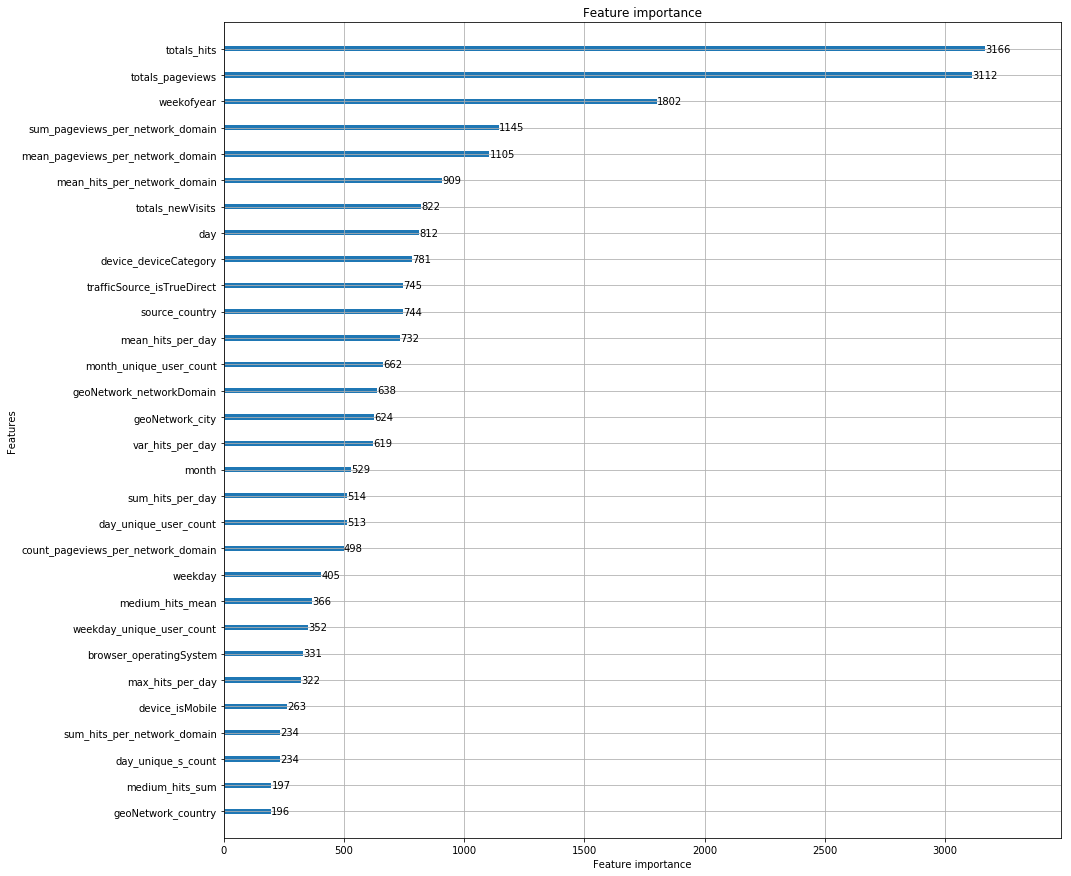

In [14]:
fig, ax = plt.subplots(figsize=(15,15))
lgb.plot_importance(model, ax=ax, max_num_features=30)  